In [1]:
from torch.utils.data import DataLoader
import numpy as np
import awkward as ak
import pickle
import os
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt

from PionModel import *
from PlottingHelperFunction import *

In [2]:
# Create an instance of the model (from PionModel).
# This can be used to train a new weights set, or can evaluate data sets using existing weight sets. 
net = NN()

# Test beams of known energies are used to test the effectiveness of the model.
# Each test beam has thousands of recorded events.
# By pushing these events through the network, the event energy predicitons should form a gaussian distribution about the true energy.
# the Standard deviation of these guess sets will be used to determine the energy resolution.
# The network will predict the correct test beam energy if the network is working effectively with the given data set.

# FilePath of the testbeam pickles pushed through the traind Network. 
# filePath = "/home/rusack/shared/pickles/HGCAL_TestBeam/pkl_files/pkl_updat_relwt_ahcaltrim_TB/"

In [4]:
# TesBeam energy sets in GeV
testBeam = [20,50,80,100,120,200,250,300]
# load in a trained network
net.load_state_dict(torch.load('/home/rusack/vadna042/PionDNNstates/exampleRun/epochfinal'))
# ensure the weights wont update
net.eval()

# Files are separated by testBeam energy. 
# Load in the summed layer energy files. 
# These are tensors 50 layers by #of events.
# Note, 50 = CE_E (28) + CE_H (12) + AHCAL (10) layers
summedEns = []
for x in testBeam:
    with open(f'/home/rusack/vadna042/DNN_HGCAL/PionData/TB_{x}/enSummed.pickle', 'rb') as a1:
        summedEns.append(torch.Tensor(pickle.load(a1)))
        del a1

# Run the summed layer events through the network
outputRun = [torch.detach(net(summedEns[i].T)).numpy() for i in range(len(summedEns))]

del summedEns
del x


<Figure size 432x288 with 0 Axes>

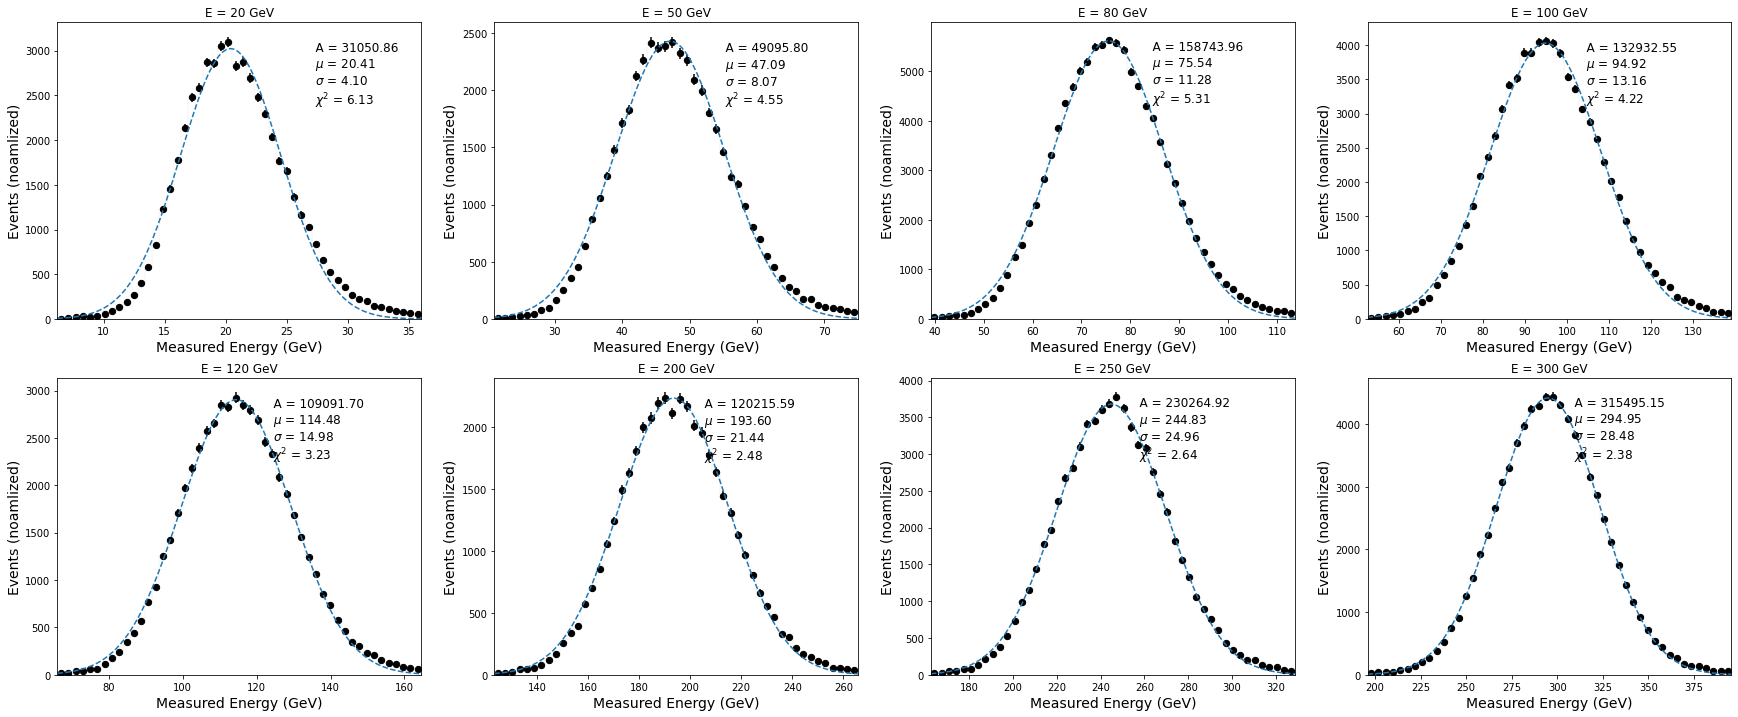

In [5]:
# The outputRun is the energy prediction for a particle given its signature

TB_DNN_parameters = []

plt.clf()
fig, axarray = plt.subplots(2, 4)
fig.set_figheight(12)
fig.set_figwidth(30)


for ie, e in enumerate(testBeam):
    irow = int(ie/4)
    jcol = int(ie%4)
#     earray = ak.sum(arrays['data'][e]['rechit_energy'], axis=1)*0.01
    earray = outputRun[ie]
    
    TB_DNN_parameters.append(fit_gaussian(earray, axarray[irow, jcol], 'data', e, irow, jcol))

# plt.savefig("/home/rusack/vadna042/DNN_HGCAL/TestbeamGauss.png")
# plt.show()


<Figure size 432x288 with 0 Axes>

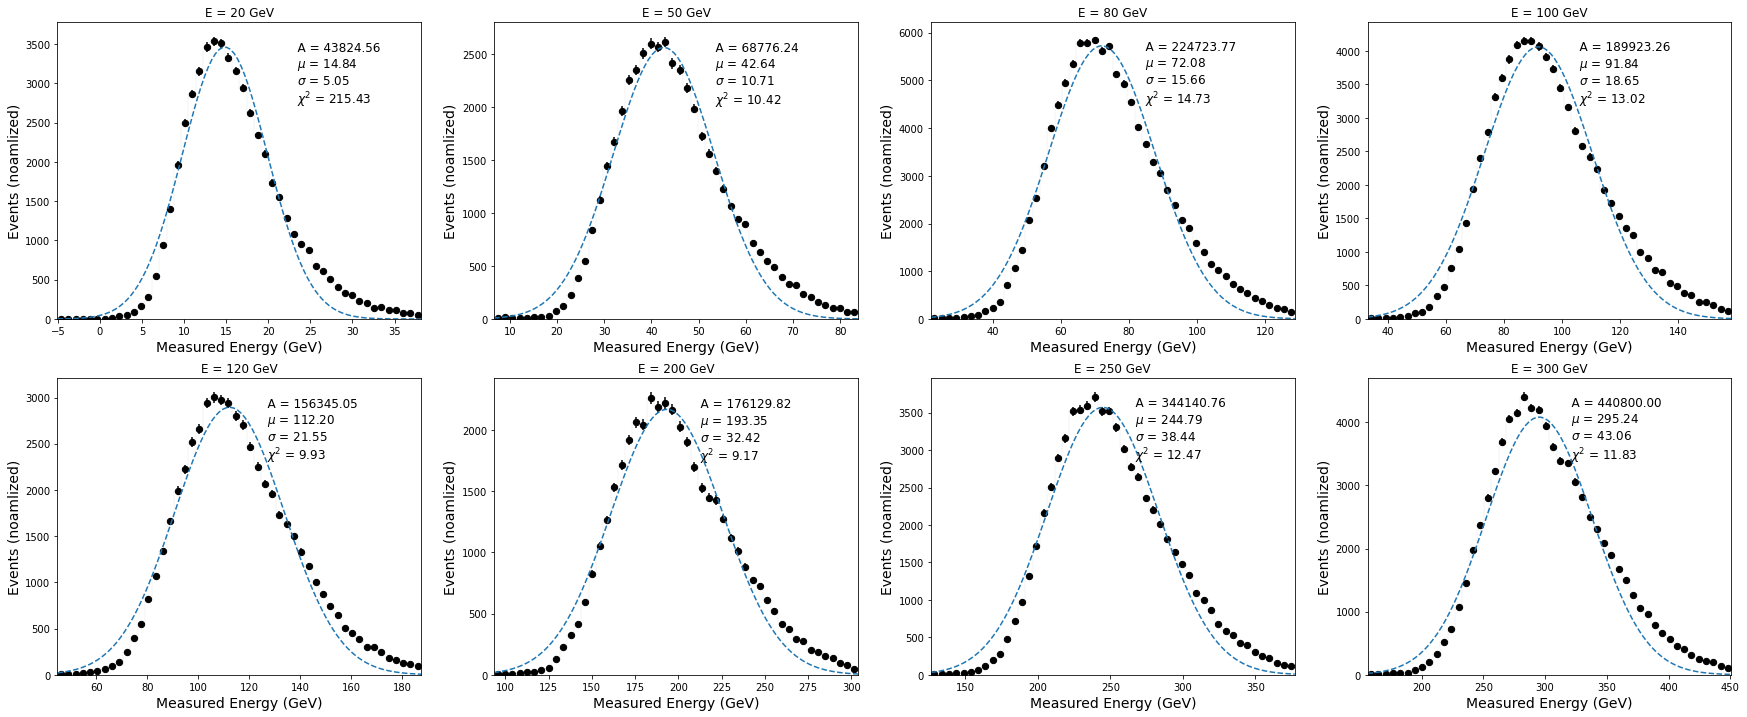

In [6]:
# To confirm the effectiveness of the network, the test beam 
# network energy guesses are compared to the energy summation method.
# These are just the sums of each recHitEn per particle per test beam energy. 
sumMethodEns = []
for x in testBeam:
    with open(f"/home/rusack/vadna042/DNN_HGCAL/PionData/TB_{x}/totalSummed.pickle", 'rb') as a:
        sumMethodEns.append(pickle.load(a))
        del a


TB_sum_parameters = []

plt.clf()
fig, axarray = plt.subplots(2, 4)
fig.set_figheight(12)
fig.set_figwidth(30)

for ie, e in enumerate(testBeam):
    irow = int(ie/4)
    jcol = int(ie%4)
    earray = sumMethodEns[ie]
    TB_sum_parameters.append(fit_gaussian(earray, axarray[irow, jcol], 'data', e, irow, jcol))


# plt.savefig("/home/rusack/vadna042/DNN_HGCAL/TestbeamSummGauss.png")
plt.show()

  
    

In [14]:
# add in the chi squared results and plot against them too.
with open("/home/rusack/vadna042/DNN_HGCAL/Outchi2Values_TBdata.txt", 'r') as f:
    aa = f.read().splitlines()
    del f
TB_chi2_parameters = [np.asarray(list(map(float, aa[i].split()))) for i in range(len(aa))]


In [15]:

# Fit a line to the energy resolution data set

#=====Create cumulative dataset
energy_x = np.asarray([1/np.sqrt(testBeam[i]) for i in range(len(TB_DNN_parameters))])
energy_y = np.asarray([TB_DNN_parameters[i][2]/testBeam[i] for i in range(len(TB_DNN_parameters))])
energy_yChi = np.asarray([TB_chi2_parameters[i][2]/testBeam[i] for i in range(len(TB_DNN_parameters))])
energy_ySM = np.asarray([TB_sum_parameters[i][2]/testBeam[i] for i in range(len(TB_sum_parameters))])
output_data = np.asarray([[energy_x[i], energy_y[i]] for i in range(len(TB_DNN_parameters))])
output_dataSM = np.asarray([[energy_x[i], energy_ySM[i]] for i in range(len(TB_sum_parameters))])
output_dataChi = np.asarray([[energy_x[i], energy_yChi[i]] for i in range(len(TB_chi2_parameters))])
    
#=====Create the guess and fit for the energy resolution lines
xarray = np.linspace(0.0, 0.55, 64)

slope = (energy_y[len(TB_DNN_parameters)-1] - energy_y[0]) / (energy_x[len(TB_DNN_parameters)-1] - energy_x[0])
intercept = energy_y[0] - slope*energy_x[0]
energy_guess = [slope,intercept]
energy_param, energy_cov = curve_fit(line, energy_x, energy_y, p0 = energy_guess)
linfit = line(xarray, energy_param[0], energy_param[1])

slopeSM = (energy_ySM[len(TB_sum_parameters)-1] - energy_ySM[0]) / (energy_x[len(TB_sum_parameters)-1] - energy_x[0])
interceptSM = energy_ySM[0] - slopeSM*energy_x[0]
energy_guessSM = [slopeSM,interceptSM]
energy_paramSM, energy_covSM = curve_fit(line, energy_x, energy_ySM, p0 = energy_guessSM)
linfitSM = line(xarray, energy_paramSM[0], energy_paramSM[1])

slopeChi = (energy_yChi[len(TB_chi2_parameters)-1] - energy_yChi[0]) / (energy_x[len(TB_chi2_parameters)-1] - energy_x[0])
interceptChi = energy_yChi[0] - slopeChi*energy_x[0]
energy_guessChi = [slopeChi,interceptChi]
energy_paramChi, energy_covChi = curve_fit(line, energy_x, energy_yChi, p0 = energy_guessChi)
linfitChi = line(xarray, energy_paramChi[0], energy_paramChi[1])

#=====plot the data and fit, check to see if params are in correct units...
# plt.figure()
# plt.plot(energy_x,energy_y, 'o', label='data')
# # plt.plot(energy_x,linfit, '-', label='fit')
# plt.legend()
# plt.xlabel('1 / $\sqrt{Energy}$')
# plt.ylabel('$\sigma_E$ / <E>')
# plt.title('data Energy Resolution plot')
# plt.text(0.11,0.1,f'Slope: {energy_param[0]}\nIntercept: {energy_param[1]}')
# # # plt.savefig('mc_h3_processed\linplot.png', dpi=350, transparent=False)
# plt.show()

<Figure size 432x288 with 0 Axes>

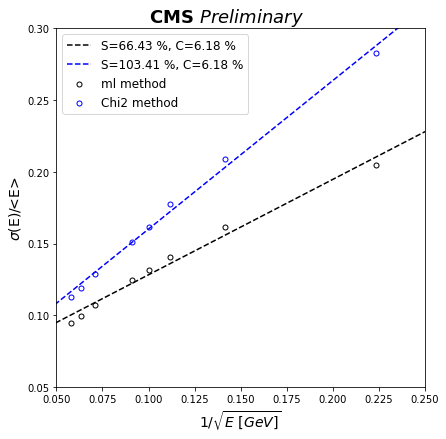

In [22]:
# Plot the energy resolution plot for the test beam data pushed through the traine network vs the summation method.

plt.clf()
plt.figure(figsize=(6.6,6.6))

# mean_e = 1/np.sqrt(np.array([ e for e in fit_parameters_ml_train]))
# res_e = np.array([ fit_parameters_ml_train[e][2]/e for e in fit_parameters_ml_train])
plt.scatter(energy_x, energy_y,
            marker='.', s=100, edgecolor='black', label='ml method',
            facecolor='w')
# res_results_ml = curve_fit(Pol1PDF, xdata=mean_e, ydata=res_e,
#          bounds = ((0,0), (1e3,1e3)), p0=(0.2, 0.02))

# res_e = np.array([fit_parameters_sum[e][2]/e for e in fit_parameters_sum])
# plt.scatter(energy_x, energy_ySM,
#             marker='.', s=100, edgecolor='red', label='Sum',
#             facecolor='w')
# res_results_sum = curve_fit(Pol1PDF, xdata=mean_e, ydata=res_e,
#          bounds = ((0,0), (1e3,1e3)), p0=(0.2, 0.02))
plt.scatter(energy_x, energy_yChi,
            marker='.', s=100, edgecolor='blue', label='Chi2 method',
            facecolor='w')



# plt.plot(xarray, linfitSM, c='red', linestyle='--',
#          label='S={:0.2f} %, C={:0.2f} %'.format(energy_paramSM[0]*100, energy_paramSM[1]*100))
plt.plot(xarray, linfit, c='black', linestyle='--',
         label='S={:0.2f} %, C={:0.2f} %'.format(energy_param[0]*100, energy_param[1]*100))
plt.plot(xarray, linfitChi, c='blue', linestyle='--',
         label='S={:0.2f} %, C={:0.2f} %'.format(energy_paramChi[0]*100, energy_param[1]*100))

cms = plt.text(x=0.1, y=0.3, s="CMS $\it{Preliminary}$",
    fontsize=18, fontweight='bold',
    fontfamily='sans-serif',
    horizontalalignment='left', 
    verticalalignment='bottom')

slope_text= plt.text(x=0.6, y=0.035, s='')

plt.ylim(0.05, 0.3)
plt.xlim(0.05, 0.25)
plt.ylabel('$\sigma$(E)/<E>', size=14)
plt.xlabel('1/$\sqrt{E\ [GeV]}$', size=14)
plt.legend(fontsize=12, loc='upper left')
plt.savefig('/home/rusack/vadna042/DNN_HGCAL/DNNtoChiComparisonPion.png', transparent=False)
plt.show()


In [ ]:
# This is the corpse of an old figure showing the relation of the average energy distributions of the layer sums 
# and the weights of the network. It was inscrutable. There was no discernable relation between the two.  

# ====load NN state
net = NN()
net.load_state_dict(torch.load('/home/rusack/vadna042/DNNstates/largeTest/epochfinal'))
net.eval()

## with open('/home/rusack/shared/pickles/hgcal_electron/flat_combined/all_target.pickle', 'rb') as f:
##     targets = pickle.load(f)
with open('/home/rusack/shared/pickles/hgcal_electron/flat_combined/layer_energy_sum.pickle', 'rb') as l:
    layerSum = pickle.load(l)
    
flat_output = torch.detach(net(torch.Tensor(layerSum)))
predictions = np.asarray(flat_output).flatten()

with open('/home/rusack/vadna042/DNNoutput/flat_0001_predictions.pickle', 'wb') as handle:
    pickle.dump(predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)

    
for i, param in enumerate(net.parameters()):
#     print(np.shape((torch.Tensor.detach(param).numpy()).T))
    if i==1:
        temp = torch.Tensor.detach(param).numpy().T
#         param_list = [sum(temp[j]) for j in range(len(temp))]
    elif i==3:
        temp2 = torch.Tensor.detach(param).numpy().T

plt.clf()
plt.figure()
plt.bar(np.linspace(0,39,40),temp)
plt.show()

plt.clf()
plt.figure()
plt.bar(np.linspace(0,29,30),temp2)
plt.show()

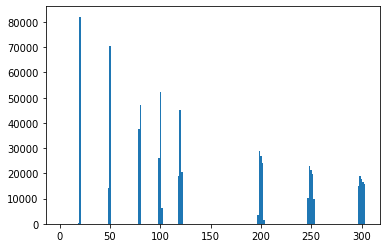

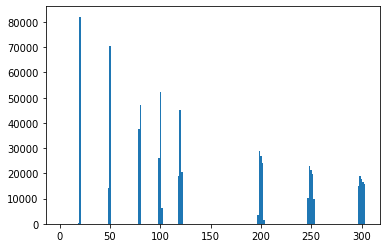

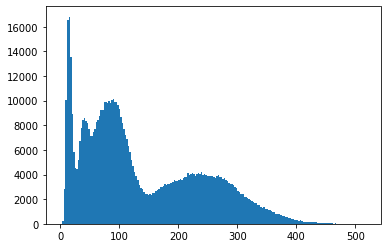

In [8]:
with open('/home/rusack/shared/pickles/HGCAL_TestBeam/pkl_files/DiscreteSim_pklFiles_Jul22/v1/FTFP_pklFiles/trueE_target.pickle', 'rb') as f:
    targets = pickle.load(f)

with open('/home/rusack/shared/pickles/HGCAL_TestBeam/pkl_files/DiscreteSim_pklFiles_Jul22/v1/FTFP_pklFiles/trueE.pickle', 'rb') as f:
    trueE = pickle.load(f)

with open('/home/rusack/shared/pickles/HGCAL_TestBeam/pkl_files/DiscreteSim_pklFiles_Jul22/v1/FTFP_pklFiles/rawE.pickle', 'rb') as f:
    rawE = pickle.load(f)



plt.clf()
plt.hist(targets, bins=200)
plt.show()

plt.clf()
plt.hist(trueE, bins=200)
plt.show()

plt.clf()
plt.hist(rawE, bins=200)
plt.show()


# # load in a trained network
# net.load_state_dict(torch.load('/home/rusack/vadna042/PionDNNstates/exampleRun/epochfinal'))
# # ensure the weights wont update
# net.eval()